In [2]:
import numpy as np
import autograd.numpy as anp
from autograd import grad, jacobian
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import dates
from src.sqr_gaussian_inference import * 
from src.gaussian_inference import *
from src.ODE_filters import *
from src.helpers import future_prediction
from src.plotting_utils import *
from tqdm import tqdm

### Plotting Specifications

In [3]:
from tueplots import axes
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 600})

In [4]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

In [5]:
from tueplots import figsizes
figsize_config = figsizes.neurips2021(nrows=2, ncols=3)
plt.rcParams.update(figsize_config)

In [6]:
plt.rcParams['figure.figsize']

[5.5, 2.266124625416281]

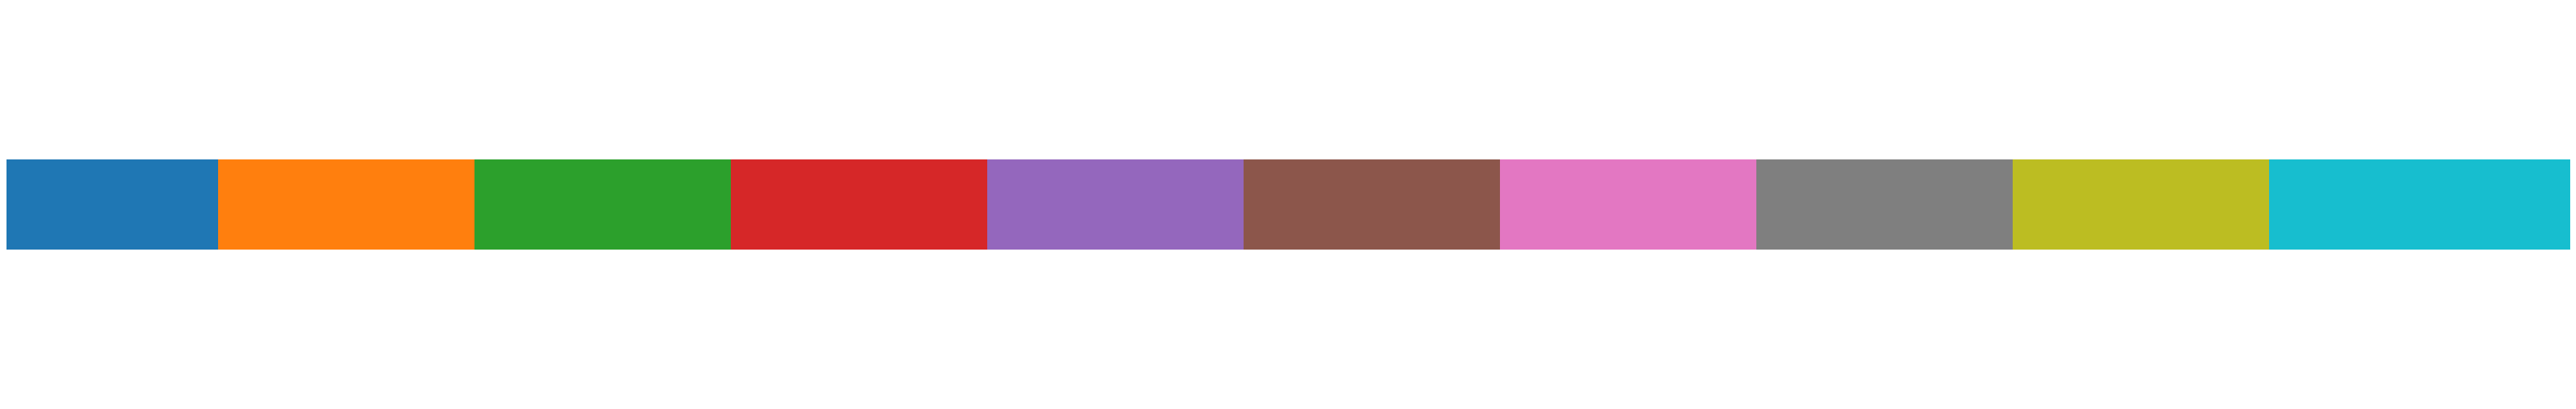

In [7]:
from cycler import cycler

# Get the color cycle from rcParams
color_cycler = plt.rcParams['axes.prop_cycle']
colors = color_cycler.by_key()['color']

# Visualize the colors
fig, ax = plt.subplots(figsize=(6, 1))
for i, color in enumerate(colors):
    ax.plot([i, i+1], [1, 1], color=color, linewidth=15)
ax.set_xlim(0, len(colors))
ax.set_ylim(0.5, 1.5)
ax.axis('off')
plt.show()

### Covid data with SIR model

In [133]:
# Data loading 
data = np.load("data_info.npz")
S = data["sird_data"][:, 0] / 1000
I = data["sird_data"][:, 1] / 1000
R = (data["sird_data"][:, 2] + data["sird_data"][:, 3]) / 1000

data_grid = np.array(data["data_grid"], dtype=int)
# print(data["date_range_x"].shape)
data_dates = data["date_range_x"][data_grid]

S = S[data_grid]
I = I[data_grid]
R = R[data_grid]

### Hyperparameters

In [134]:
alpha = 1e-6
trafo = lambda x: (1+alpha)/(1 + anp.exp(-x)) - alpha/2

def inv_trafo(y):
    z = (y + alpha / 2) / (1 + alpha)
    return anp.log(z) - anp.log(1 - z)

In [152]:
# hyperparameters
beta_0 = inv_trafo(0.22)
beta_sgm = 0.1
std_beta_0 = beta_sgm
std_beta_0_prime = beta_sgm
std_beta_0_prime_prime = beta_sgm

gamma=0.06 # this at the moment is acutally the recovery+the death rate in one

sigma_x = 0.00001 #this is the ouput scale at the moment for all S, I, R,
sigma_beta = 0.03 #output scale for beta

std_R_I = 0.0005 #this is the observation uncertainty at the moment for the whole pde info and conservation
std_R_x = 0.01*0.0005 #this is the uncertainty in observing the infected count

In [153]:
beta_0

np.float64(-1.2656647416320213)

In [154]:
#define the ODE x_dot = f(x)
Pop=S[0]+I[0]+R[0]


def vf(x):
    beta = trafo(x[3]) # transform
    return anp.array([
        -1 * beta*x[0]*x[1],
        beta*x[0]*x[1] - gamma*x[1],
        gamma*x[1],
        0
    ])

#define the initial value
y0 = anp.array([S[0], I[0], R[0], beta_0])

#set dimenisons
d, q = 4, 2

#Prior model for q=2 TODO: generalize this for variable q
A = lambda h: anp.array([[1.0, h, h**2/2.0], [0.0, 1.0, h], [0.0, 0.0, 1.0]])
Q = lambda h: anp.array([[h**5/20.0, h**4/8.0, h**3/6.0],
                                    [h**4/8.0, h**3/3.0, h**2/2.0],
                                    [h**3/6.0, h**2/2.0, h]])

# Taylor-mode init via autograd for q=2
Jvf = jacobian(vf)
x1 = vf(y0)
x2 = anp.dot(Jvf(y0), x1)  # second derivative
#print(x2,Jvf(y0)@x1)
mu_0 = anp.concatenate([y0, x1, x2])  # shape (d*(q+1),)
#mu_0 = np.concat([y0, vf(y0), np.zeros(d)])
Sigma_0 = anp.eye(d*(q+1)) * 0.0
Sigma_0[3,3]=1. * std_beta_0
Sigma_0[7,7]=1. * std_beta_0_prime
Sigma_0[11,11]=1. * std_beta_0_prime_prime

# Discretization
t0, t1 = data_grid[0], data_grid[-1]
N = data_grid.shape[0] - 1
h = (t1 - t0) / N

# Constant step consequences
A_h =  anp.kron(A(h), anp.eye(d))
Q_h = anp.kron(Q(h), anp.diag([sigma_x, sigma_x, sigma_x, sigma_beta])**2)
b_h = anp.zeros((q+1)*d)
R_h = anp.eye(d)

#valid projections for q=2, TODO: generalize for variable q
E0 = anp.array([1., 0., 0.])
E1 = anp.array([0., 1., 0.])
E0 = anp.kron(E0, anp.eye(d))
E1 = anp.kron(E1, anp.eye(d))

# Measurement operator: x_dot - f(x) = 0
def g_conserved(X):
    #normnal measurement 
    x = anp.dot(E0, X)
    x_dot = anp.dot(E1, X)
    z_ode = x_dot - vf(x)
    #conservation
    z_conserved = anp.array([Pop-anp.sum(x[:3])])
    #Actual observation of Infected persons
    z_observation = anp.array([x[1]])

    return anp.concatenate([z_ode[:3], z_conserved, z_observation])

jacobian_g_conserved = jacobian(g_conserved)
z_sequence_conserved = anp.zeros((N, d+1))
z_sequence_conserved[:,-1] = I[1:]

R_h_conserved = anp.eye(d+1)
R_h_conserved[-1,-1] = std_R_I
R_h_conserved[:4, :4] *= std_R_x

assert jacobian_g_conserved(mu_0).shape == (d+1, 3*d), f"Unexpected shape: {jacobian_g_conserved(mu_0).shape}"

In [155]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h_conserved, g_conserved, jacobian_g_conserved, z_sequence_conserved, N)

m_sequence, P_sequence = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

In [156]:
political_events = [
    np.datetime64("2020-03-22"),
    np.datetime64("2020-05-06"),
    np.datetime64("2020-10-07"),
    np.datetime64("2020-11-02"),
    np.datetime64("2020-12-16"),
    np.datetime64("2021-04-23"),
]

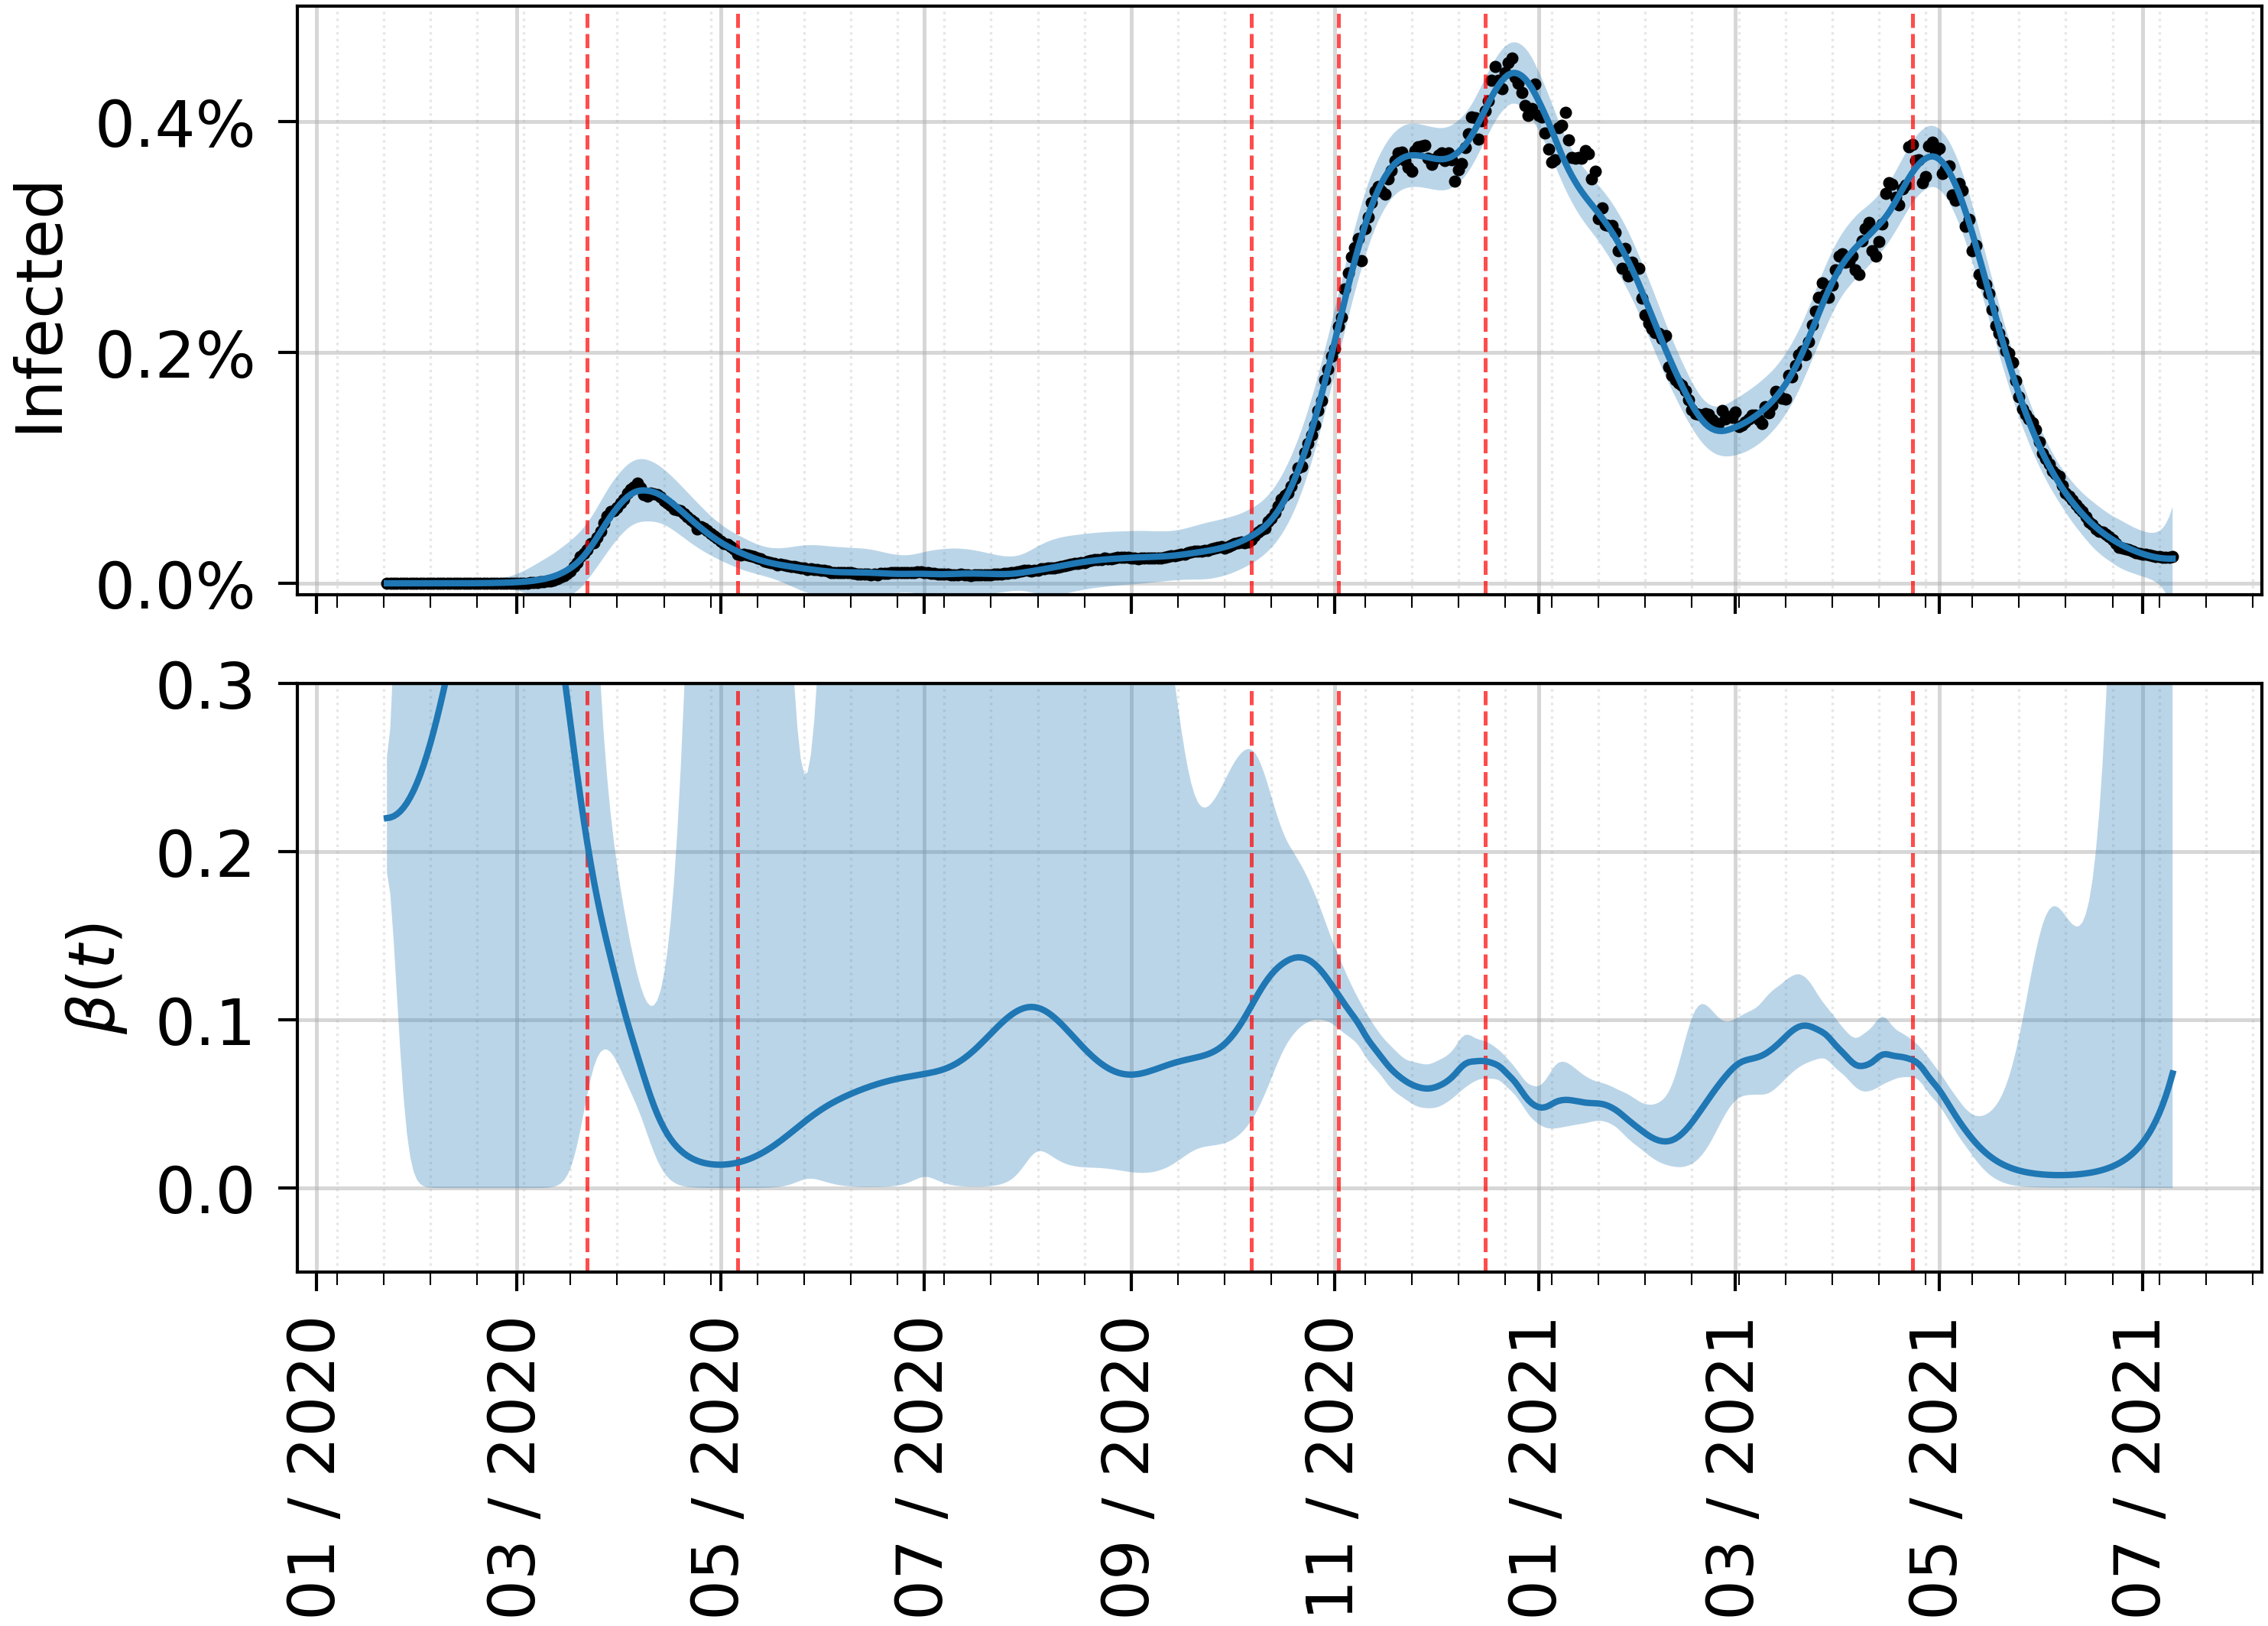

In [160]:

fig, axs = plt.subplots(2, 1, figsize=(5, 3.6), sharex=True)

# First subplot: Infected
ax = axs[0]
col = 1
ylab = "Infected"
ylim = [-0.0001, 0.005]
ax.plot(data_dates, m_sequence[:, col])
P = P_sequence[:, col, col]
margin = 2 * np.sqrt(P)
ax.fill_between(data_dates, m_sequence[:, col]-margin, m_sequence[:, col]+margin, alpha=0.3)
ax.scatter(data_dates, I, color='black', s=2)
ax.set_ylabel(ylab)
ax.set_ylim(ylim)
ax.grid(True, which='major', axis='both', linestyle='-', linewidth=0.6, alpha=0.5)
ax.xaxis.set_minor_locator(dates.WeekdayLocator(interval=2))
ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.4, alpha=0.3)

# Second subplot: β(t)
ax = axs[1]
col = 3
ylab = r'$\beta(t)$'
ylim = [-0.05, 0.3]
ax.plot(data_dates, trafo(m_sequence[:,col]))
P = P_sequence[:, col, col]
margin = 2 * np.sqrt(P)
upper = trafo(m_sequence[:,col] + margin)
lower = trafo(m_sequence[:,col] - margin)
ax.fill_between(data_dates, lower, upper, alpha=0.3)
ax.set_ylabel(ylab)
ax.set_ylim(ylim)
ax.grid(True, which='major', axis='both', linestyle='-', linewidth=0.6, alpha=0.5)
ax.xaxis.set_minor_locator(dates.WeekdayLocator(interval=2))
ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.4, alpha=0.3)

# Add political events as vertical lines to both subplots
for event_date in political_events:
    axs[0].axvline(event_date, color='red', linestyle='--', linewidth=0.6, alpha=0.7, zorder=1)
    axs[1].axvline(event_date, color='red', linestyle='--', linewidth=0.6, alpha=0.7, zorder=1)

axs[0].yaxis.set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda x, _: f"{x*100:.1f}%")
)

axs[1].xaxis.set_tick_params(rotation=90, labelsize=plt.rcParams['xtick.labelsize'])
axs[1].xaxis.set_major_formatter(dates.DateFormatter("%m / %Y"))

plt.show()

In [67]:
### Interactive plot - CLEAN VERSION
import ipywidgets as widgets

# Defaults
DEF = {'beta_0': 0.22, 'gamma': 0.06, 'std_beta_0': 0.01, 'std_beta_0_prime': 0.01,
       'std_beta_0_prime_prime': 0.01, 'sigma_x': 0.00001, 'sigma_beta': 0.0003,
       'std_R_I': 0.0005, 'std_R_x': 0.000005}

def run_filter(beta_0, gamma, std_beta_0, std_beta_0_prime, std_beta_0_prime_prime,
               sigma_x, sigma_beta, std_R_I, std_R_x):
    Pop = S[0] + I[0] + R[0]
    def vf_l(x): return anp.array([-x[3]*x[0]*x[1], x[3]*x[0]*x[1]-gamma*x[1], gamma*x[1], 0])
    y0 = anp.array([S[0], I[0], R[0], beta_0])
    d, q = 4, 2
    A_f = lambda h: anp.array([[1., h, h**2/2.], [0., 1., h], [0., 0., 1.]])
    Q_f = lambda h: anp.array([[h**5/20., h**4/8., h**3/6.], [h**4/8., h**3/3., h**2/2.], [h**3/6., h**2/2., h]])
    Jvf = jacobian(vf_l)
    x1 = vf_l(y0)
    x2 = anp.dot(Jvf(y0), x1)
    mu_0 = anp.concatenate([y0, x1, x2])
    Sigma_0 = anp.eye(d*(q+1)) * 0.0
    Sigma_0[3,3], Sigma_0[7,7], Sigma_0[11,11] = std_beta_0, std_beta_0_prime, std_beta_0_prime_prime
    t0, t1 = data_grid[0], data_grid[-1]
    N = data_grid.shape[0] - 1
    h = (t1 - t0) / N
    A_h = anp.kron(A_f(h), anp.eye(d))
    Q_h = anp.kron(Q_f(h), anp.diag([sigma_x, sigma_x, sigma_x, sigma_beta])**2)
    b_h = anp.zeros((q+1)*d)
    E0 = anp.kron(anp.array([1., 0., 0.]), anp.eye(d))
    E1 = anp.kron(anp.array([0., 1., 0.]), anp.eye(d))
    def g_c(X):
        x = anp.dot(E0, X)
        x_dot = anp.dot(E1, X)
        z_ode = x_dot - vf_l(x)
        z_conserved = anp.array([Pop - anp.sum(x[:3])])
        z_observation = anp.array([x[1]])
        return anp.concatenate([z_ode[:3], z_conserved, z_observation])
    jac_g = jacobian(g_c)
    z_seq = anp.zeros((N, d+1))
    z_seq[:,-1] = I[1:]
    R_h = anp.eye(d+1)
    R_h[-1,-1], R_h[:4,:4] = std_R_I, std_R_x * anp.eye(4)
    m_s, P_s, m_p, P_p = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g_c, jac_g, z_seq, N)
    m_s, P_s = compute_kalman_backward(m_s, P_s, m_p, P_p, A_h, N)
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 3.6), sharex=True)
    for ax, col, ylab, ylim in [(axs[0], 1, "Infected", [-0.0001, 0.005]), (axs[1], 3, r'$\beta(t)$', [-0.05, 0.3])]:
        ax.plot(data_dates, m_s[:, col])
        margin = 2 * np.sqrt(P_s[:, col, col])
        ax.fill_between(data_dates, m_s[:, col]-margin, m_s[:, col]+margin, alpha=0.3)
        if col == 1: ax.scatter(data_dates, I, color='black', s=2)
        ax.set_ylabel(ylab, fontsize=8)
        ax.set_ylim(ylim)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, which='major', axis='both', linestyle='-', linewidth=0.6, alpha=0.5)
        ax.xaxis.set_minor_locator(dates.WeekdayLocator(interval=2))
        ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.4, alpha=0.3)
    for ed in political_events:
        axs[0].axvline(ed, color='red', linestyle='--', linewidth=0.6, alpha=0.7, zorder=1)
        axs[1].axvline(ed, color='red', linestyle='--', linewidth=0.6, alpha=0.7, zorder=1)
    axs[0].yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f"{x*100:.1f}%"))
    axs[1].xaxis.set_tick_params(rotation=90, labelsize=7)
    axs[1].xaxis.set_major_formatter(dates.DateFormatter("%m / %Y"))
    plt.show()

# Widgets with compact layout
st = {'description_width': '70px'}
lay = widgets.Layout(width='220px')

w1 = widgets.FloatSlider(value=DEF['beta_0'], min=0.05, max=0.5, step=0.01,
                          description='β₀', style=st, layout=lay, continuous_update=False)
w2 = widgets.FloatSlider(value=DEF['gamma'], min=0.01, max=0.2, step=0.01,
                          description='γ', style=st, layout=lay, continuous_update=False)
w3 = widgets.FloatLogSlider(value=DEF['std_beta_0'], min=-4, max=-1, step=0.1,
                             description='σ(β₀)', style=st, layout=lay, continuous_update=False)
w4 = widgets.FloatLogSlider(value=DEF['std_beta_0_prime'], min=-4, max=-1, step=0.1,
                             description="σ(β₀')", style=st, layout=lay, continuous_update=False)
w5 = widgets.FloatLogSlider(value=DEF['std_beta_0_prime_prime'], min=-4, max=-1, step=0.1,
                             description="σ(β₀'')", style=st, layout=lay, continuous_update=False)
w6 = widgets.FloatLogSlider(value=DEF['sigma_x'], min=-7, max=-3, step=0.1,
                             description='σₓ', style=st, layout=lay, continuous_update=False)
w7 = widgets.FloatLogSlider(value=DEF['sigma_beta'], min=-5, max=-2, step=0.1,
                             description='σᵦ', style=st, layout=lay, continuous_update=False)
w8 = widgets.FloatLogSlider(value=DEF['std_R_I'], min=-6, max=-2, step=0.1,
                             description='σ(I)', style=st, layout=lay, continuous_update=False)
w9 = widgets.FloatLogSlider(value=DEF['std_R_x'], min=-7, max=-3, step=0.1,
                             description='σ(x)', style=st, layout=lay, continuous_update=False,
                             readout_format='.2e')

def reset_all(b):
    w1.value = DEF['beta_0']
    w2.value = DEF['gamma']
    w3.value = DEF['std_beta_0']
    w4.value = DEF['std_beta_0_prime']
    w5.value = DEF['std_beta_0_prime_prime']
    w6.value = DEF['sigma_x']
    w7.value = DEF['sigma_beta']
    w8.value = DEF['std_R_I']
    w9.value = DEF['std_R_x']

btn = widgets.Button(description='Reset', button_style='info', layout=widgets.Layout(width='100px'))
btn.on_click(reset_all)

# Layout - sliders on top with centered headers
header_style = "<div style='text-align:center; margin-bottom:5px'><b>{}</b></div>"

c1 = widgets.VBox([widgets.HTML(header_style.format("Model")), w1, w2],
                   layout=widgets.Layout(width='230px'))
c2 = widgets.VBox([widgets.HTML(header_style.format("Initialization")), w3, w4, w5],
                   layout=widgets.Layout(width='230px'))
c3 = widgets.VBox([widgets.HTML(header_style.format("Process Noise")), w6, w7],
                   layout=widgets.Layout(width='230px'))
c4 = widgets.VBox([widgets.HTML(header_style.format("Observation Noise")), w8, w9],
                   layout=widgets.Layout(width='230px'))

# Arrange sliders horizontally on top
controls_row = widgets.HBox([c1, c2, c3, c4])

# Create output widget for plot
out = widgets.interactive_output(run_filter, {
    'beta_0': w1, 'gamma': w2,
    'std_beta_0': w3, 'std_beta_0_prime': w4, 'std_beta_0_prime_prime': w5,
    'sigma_x': w6, 'sigma_beta': w7,
    'std_R_I': w8, 'std_R_x': w9
})

# Display sliders on top, plot below, reset button at bottom
display(widgets.VBox([
    controls_row,
    out,
    widgets.HBox([btn], layout=widgets.Layout(justify_content='center'))
]))
